In [1]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_core.documents import Document

Loader = PyPDFLoader("./book_1.pdf")
documents = Loader.lazy_load()
pages = []
doc_intro = Document(
    page_content='This book is "Zero to One, notes on startups, or how to build the future" by Peter Thiel.',
    metadata={"source": "manually added", "page": 0}
)
pages.append(doc_intro)
for doc in documents:
    if 1 < doc.metadata["page"] <= 28:  # Assuming page numbers start at 0
        pages.append(doc)
    elif doc.metadata["page"] > 28:
        break

pages

[Document(metadata={'source': 'manually added', 'page': 0}, page_content='This book is "Zero to One, notes on startups, or how to build the future" by Peter Thiel.'),
 Document(metadata={'producer': 'iOS Version 18.5 (Build 22F76) Quartz PDFContext', 'creator': 'PyPDF', 'creationdate': "D:20250703112818Z00'00'", 'moddate': "D:20250703112818Z00'00'", 'source': './book_1.pdf', 'total_pages': 160, 'page': 2, 'page_label': '3'}, page_content='Copyright © 2014 by Peter Thiel\nAll rights reserved.\nPublished in the United States by Crown Business, an imprint of the Crown Publishing Group, a division of Random House LLC, a\nPenguin Random House Company, New York.\nwww.crownpublishing.com\nCROWN BUSINESS is a trademark and CROWN and the Rising Sun colophon are registered trademarks of Random House LLC.\nCrown Business books are available at special discounts for bulk purchases for sales promotions or corporate use. Special editions,\nincluding personalized covers, excerpts of existing books, o

In [5]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=200, chunk_overlap=0, add_start_index=True)  # track index in original document
texts = text_splitter.split_documents(pages)

texts

len(texts)

281

In [3]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

embeddings_model


HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2', cache_folder=None, model_kwargs={}, encode_kwargs={}, query_encode_kwargs={}, multi_process=False, show_progress=False)

In [ ]:
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS

db = FAISS.from_documents(texts, embeddings_model)

db.index.ntotal

db.save_local("faiss_index")

In [6]:
retriever = db.as_retriever()

In [7]:
from dotenv import load_dotenv
load_dotenv("project.env")  # This loads .env variables into os.environ

True

In [8]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt", api_url="https://api.smith.langchain.com")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [12]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [9]:
import getpass
import os

if "GROQ_API_KEY" not in os.environ:
    os.environ["GROQ_API_KEY"] = getpass.getpass("Enter your Groq API key: ")

In [13]:
from langchain_groq import ChatGroq
llm = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0,
)

def retrieve(state: State):
    retrieved_docs = db.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [15]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

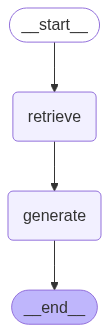

In [16]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
result = graph.invoke({"question": "why do monopolists lie?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='57bbc9db-568b-4b69-8e96-4bf8120f2711', metadata={'producer': 'iOS Version 18.5 (Build 22F76) Quartz PDFContext', 'creator': 'PyPDF', 'creationdate': "D:20250703112818Z00'00'", 'moddate': "D:20250703112818Z00'00'", 'source': './book_1.pdf', 'total_pages': 160, 'page': 22, 'page_label': '23', 'start_index': 688}, page_content='Monopolists lie to protect themselves. They know that bragging about their great monopoly invites'), Document(id='e59e9104-9ad0-44f7-9c7a-4ffac1c8bade', metadata={'producer': 'iOS Version 18.5 (Build 22F76) Quartz PDFContext', 'creator': 'PyPDF', 'creationdate': "D:20250703112818Z00'00'", 'moddate': "D:20250703112818Z00'00'", 'source': './book_1.pdf', 'total_pages': 160, 'page': 26, 'page_label': '27', 'start_index': 1524}, page_content='about things other than making money; non-monopolists can’t. In perfect competition, a business is so'), Document(id='cf95f521-0f1c-4867-bd55-4d09d10c1150', metadata={'producer': 'iOS Version 18.5 (Build 22F7